In [1]:
import os
import glob
import numpy as np
from utils.utils import group_weekly
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')

SurfacePressure -> Wind, Temperature, Migration <br/>
Wind -> Humidity, CloudCoverage <br/>
Temperature -> Humidity, CloudCoverage, NDVI <br/>
Humidity -> Rain, NDVI <br/>
CloudCoverage -> Rain, NDVI <br/>
Rain -> NDVI <br/>
Longitude -> Temperature, Wind, SurfacePressure <br/>
Latitude -> Temperature, Wind, SurfacePressure <br/>
NDVI -> Migration <br/>

### Load and concatenate data

In [2]:
concatenated_df = pd.DataFrame()

# Iterate over files in the folder
for file_path in glob.glob(os.path.join('data', 'StorkMigrationWithNDVIWeather*.csv')):
    data = pd.read_csv(file_path)
    if 'Unnamed: 0' in data.columns:
        data = data.drop(['Unnamed: 0'],axis=1)
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    result_data = group_weekly(data)
    concatenated_df = pd.concat([concatenated_df, result_data])

print(concatenated_df.shape)
concatenated_df.to_csv(os.path.join('data','GrouppedByData.csv'))
print('Csv file created')
concatenated_df['timestamp']=pd.to_datetime(concatenated_df['timestamp'])
concatenated_df = concatenated_df.dropna()
copy_concatenated_df = concatenated_df.copy()

(250, 13)
Csv file created


In [3]:
display(concatenated_df.head())

,tag-local-identifier,timestamp,NDVI,temperature_2m,relative_humidity_2m,rain,surface_pressure,cloud_cover,wind_speed_100m,distance-flown,location-lat,location-long,distance-traveled
1,2301,2014-04-07,1.000000,27.166506,75.406218,0.0,1012.119917,19.424948,17.504099,190.006150,52.939327,11.787121,80.332094
2,2301,2014-04-14,1.000000,27.296474,72.291403,0.0,1013.621793,5.509615,9.664323,8.633323,52.939315,11.787140,0.001848
3,2301,2015-01-26,0.311800,7.368060,31.763185,0.0,912.871041,1.088406,15.018297,4867.366319,11.628961,25.130908,4734.574226
4,2301,2015-02-02,0.276642,10.896092,30.919514,0.0,915.741864,5.623704,17.692069,935.171770,11.499063,24.830863,35.742784
5,2301,2015-02-09,0.189800,16.451284,18.642753,0.0,929.048683,4.644090,21.572337,1119.210112,11.238312,27.654547,309.548916


In [4]:
result = concatenated_df.groupby('tag-local-identifier').agg({'timestamp': ['count', 'min', 'max']}).reset_index()

# Rename columns for clarity
result.columns = ['value', 'count', 'min_timestamp', 'max_timestamp']

display(result)

,value,count,min_timestamp,max_timestamp
0,1787,7,2013-03-11,2013-04-22
1,1791,28,2013-03-11,2015-04-20
2,1793,28,2013-03-11,2015-04-13
3,1794,17,2013-03-11,2014-04-14
4,1796,18,2013-03-11,2014-04-07
5,1797,20,2014-02-10,2015-04-13
6,2301,41,2013-03-11,2016-04-11
7,2303,9,2013-03-11,2013-05-06
8,2305,18,2013-03-11,2014-04-07
9,2306,37,2013-03-11,2016-04-11


### Data Discretization

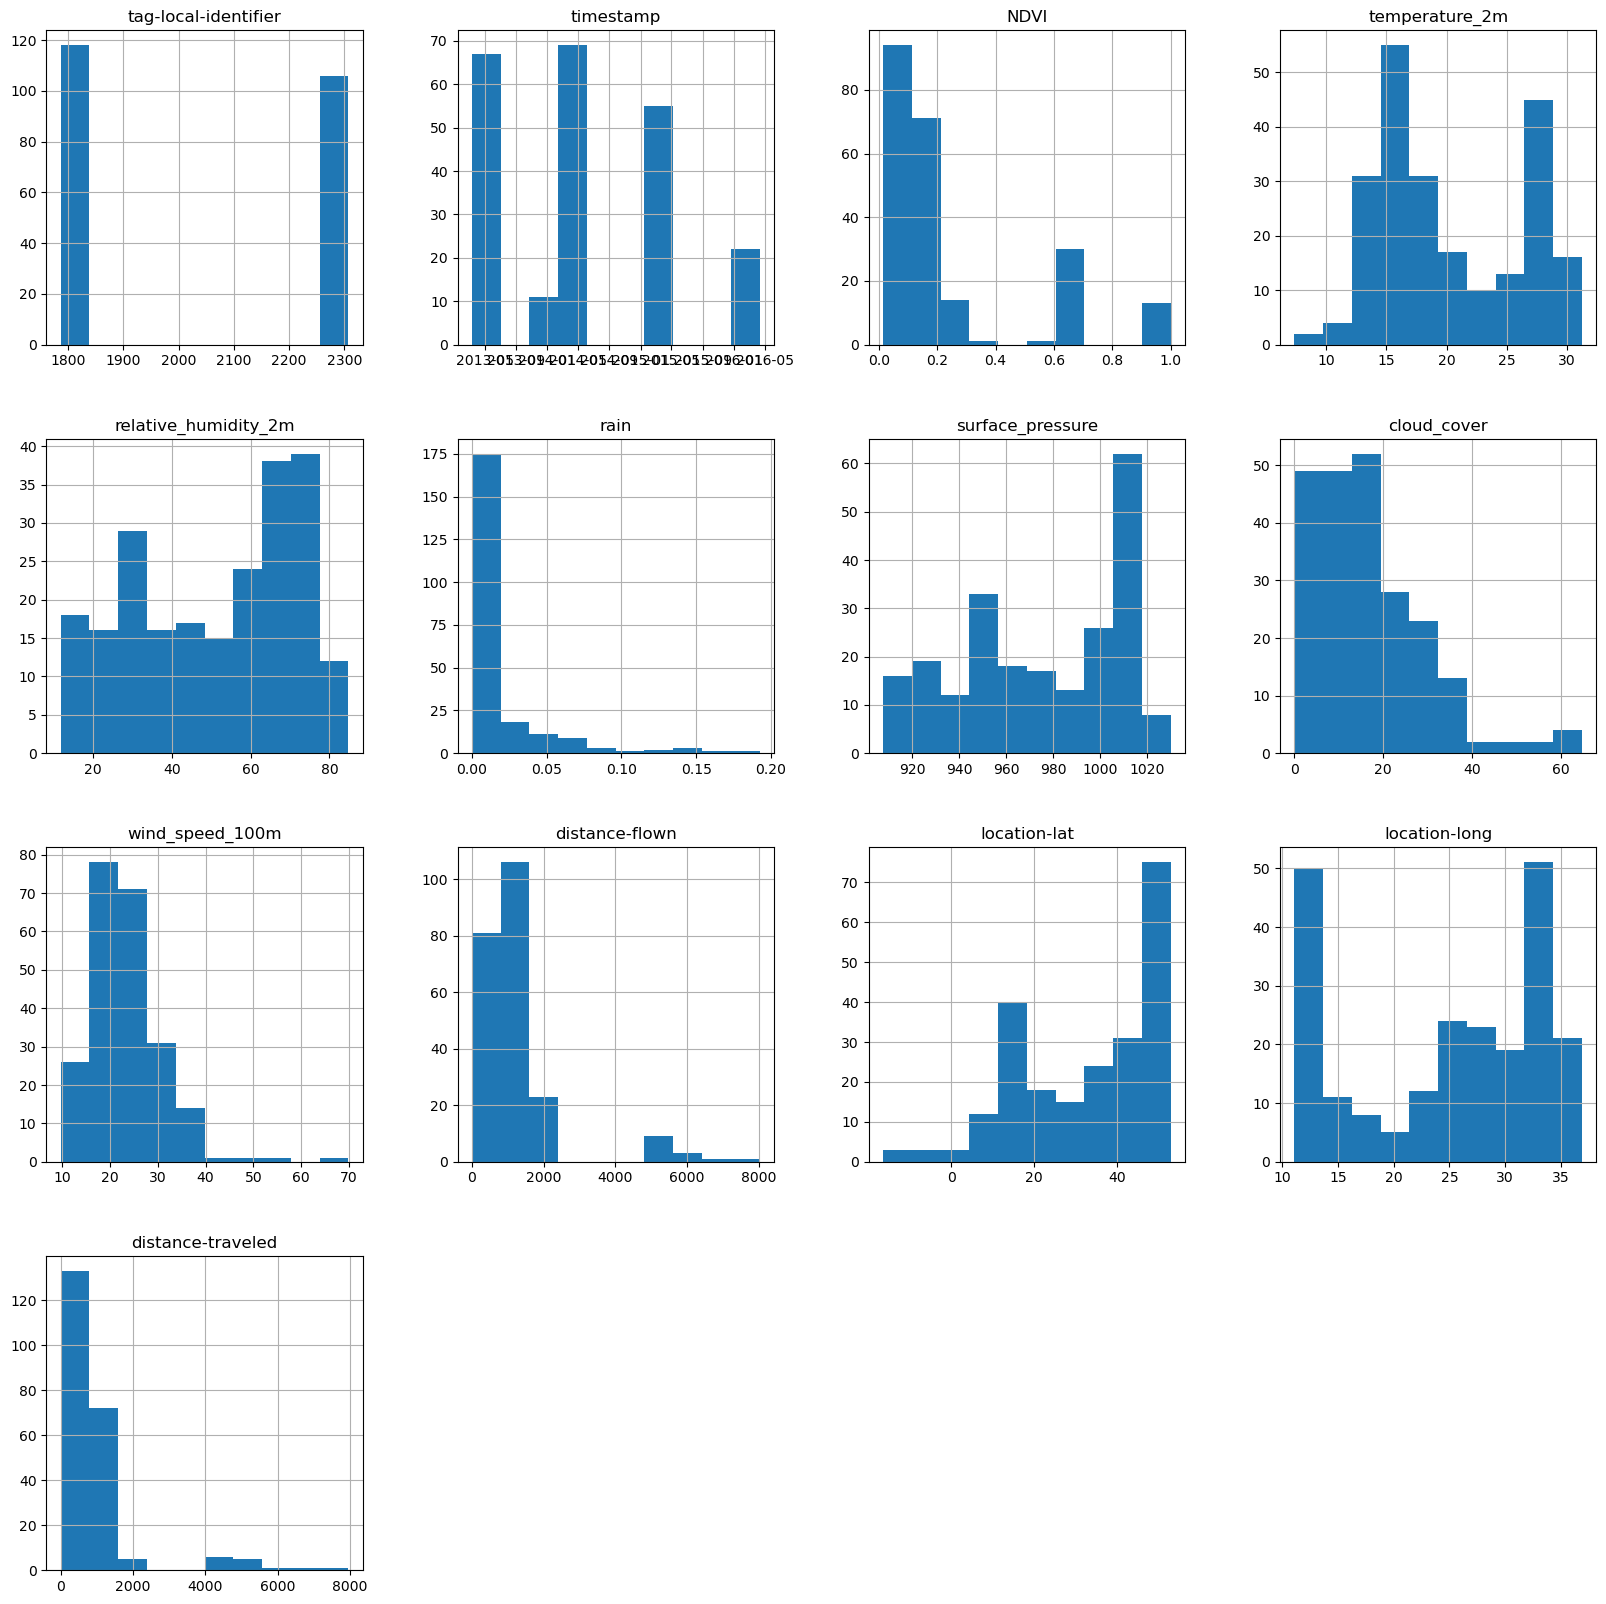

In [5]:
concatenated_df.hist(figsize=(20,20))
plt.show()

Explain dropped columns and why

In [6]:
concatenated_df = copy_concatenated_df.copy()
print(concatenated_df.columns)

Index(['tag-local-identifier', 'timestamp', 'NDVI', 'temperature_2m',
       'relative_humidity_2m', 'rain', 'surface_pressure', 'cloud_cover',
       'wind_speed_100m', 'distance-flown', 'location-lat', 'location-long',
       'distance-traveled'],
      dtype='object')


In [7]:
concatenated_df = concatenated_df.drop(['distance-flown'],axis=1)
new_column_names = ['Stork_id', 'Timestamp', 'NDVI', 'Temperature', 'RelativeHumidity', 'Rain', 'SurfacePressure', 'CloudCover', 'WindSpeed',
                    'LastLatitude', 'LastLongitude','Migrating']
concatenated_df.columns = new_column_names
concatenated_df = concatenated_df.round(4)
display(concatenated_df.head())

,Stork_id,Timestamp,NDVI,Temperature,RelativeHumidity,Rain,SurfacePressure,CloudCover,WindSpeed,LastLatitude,LastLongitude,Migrating
1,2301,2014-04-07,1.0000,27.1665,75.4062,0.0,1012.1199,19.4249,17.5041,52.9393,11.7871,80.3321
2,2301,2014-04-14,1.0000,27.2965,72.2914,0.0,1013.6218,5.5096,9.6643,52.9393,11.7871,0.0018
3,2301,2015-01-26,0.3118,7.3681,31.7632,0.0,912.8710,1.0884,15.0183,11.6290,25.1309,4734.5742
4,2301,2015-02-02,0.2766,10.8961,30.9195,0.0,915.7419,5.6237,17.6921,11.4991,24.8309,35.7428
5,2301,2015-02-09,0.1898,16.4513,18.6428,0.0,929.0487,4.6441,21.5723,11.2383,27.6545,309.5489


In [8]:
# concatenated_df is assumed to be defined elsewhere in your code

# Specify the columns you want to discretize
columns_to_discretize = [ 'NDVI', 'Temperature', 'RelativeHumidity', 'Rain', 'SurfacePressure', 'CloudCover', 'WindSpeed','Migrating']
# Specify the number of bin
number_of_bins = [2,3,2,2,2,2,2,2]

# Reset the index of concatenated_df to avoid duplicate index values
concatenated_df.reset_index(drop=True, inplace=True)

bin_names_dictionary = dict()

# Sort DataFrame by the column you are discretizing
for i in range(0,len(columns_to_discretize)):
    column = columns_to_discretize[i]
    num_bins = number_of_bins[i]
    bin_names_dictionary[column] = {}
    
    # Sort DataFrame by the column
    df_sorted = concatenated_df.sort_values(by=column)
    
    # Discretize values into bins with equal number of records
    discretized_column, bin_edges = pd.qcut(df_sorted[column], q=num_bins, labels=False, duplicates='drop', retbins=True)

    # Create a DataFrame containing the discretized values and bin edges
    result_table = pd.DataFrame({
        'Bin_edge_low_' + column: bin_edges[:-1],
        'Bin_edge_high_' + column: bin_edges[1:]
    })  # Use the same index as the sorted DataFrame

    for ind,row in result_table[:-1].iterrows():
        if column =='Rain':
            bin_names_dictionary[column][ind]=f'< {round(row[f"Bin_edge_high_" + column],6)}'
        else:
            bin_names_dictionary[column][ind]=f'< {round(row[f"Bin_edge_high_" + column],2)}'
    bin_names_dictionary[column][ind]=f'> {round(result_table.iloc[-1][f"Bin_edge_low_" + column],2)}'
    # Write dictionary string to a text file
    with open(os.path.join('data','Labels_dictionary_for discretization.txt'), 'w') as file:
        file.write(str(bin_names_dictionary))
    display(result_table)
    
    # Merge result_table with the original DataFrame to retain other columns
    concatenated_df[column] = discretized_column


display(concatenated_df.head())

,Bin_edge_low_NDVI,Bin_edge_high_NDVI
0,0.0149,0.1674
1,0.1674,1.0000


,Bin_edge_low_Temperature,Bin_edge_high_Temperature
0,7.368100,16.142233
1,16.142233,23.733133
2,23.733133,31.220500


,Bin_edge_low_RelativeHumidity,Bin_edge_high_RelativeHumidity
0,11.71350,55.86305
1,55.86305,84.79620


,Bin_edge_low_Rain,Bin_edge_high_Rain
0,0.00000,0.00145
1,0.00145,0.19230


,Bin_edge_low_SurfacePressure,Bin_edge_high_SurfacePressure
0,907.6792,979.3278
1,979.3278,1030.1427


,Bin_edge_low_CloudCover,Bin_edge_high_CloudCover
0,0.0000,14.1687
1,14.1687,64.8263


,Bin_edge_low_WindSpeed,Bin_edge_high_WindSpeed
0,9.66430,22.11635
1,22.11635,69.85380


,Bin_edge_low_Migrating,Bin_edge_high_Migrating
0,0.00110,700.31795
1,700.31795,7951.88110


,Stork_id,Timestamp,NDVI,Temperature,RelativeHumidity,Rain,SurfacePressure,CloudCover,WindSpeed,LastLatitude,LastLongitude,Migrating
0,2301,2014-04-07,1,2,1,0,1,1,0,52.9393,11.7871,0
1,2301,2014-04-14,1,2,1,0,1,0,0,52.9393,11.7871,0
2,2301,2015-01-26,1,0,0,0,0,0,0,11.6290,25.1309,1
3,2301,2015-02-02,1,0,0,0,0,0,0,11.4991,24.8309,0
4,2301,2015-02-09,1,1,0,0,0,0,0,11.2383,27.6545,0


In [9]:
display(bin_names_dictionary)

{'NDVI': {0: '> 0.17'},
 'Temperature': {0: '< 16.14', 1: '> 23.73'},
 'RelativeHumidity': {0: '> 55.86'},
 'Rain': {0: '> 0.0'},
 'SurfacePressure': {0: '> 979.33'},
 'CloudCover': {0: '> 14.17'},
 'WindSpeed': {0: '> 22.12'},
 'Migrating': {0: '> 700.32'}}

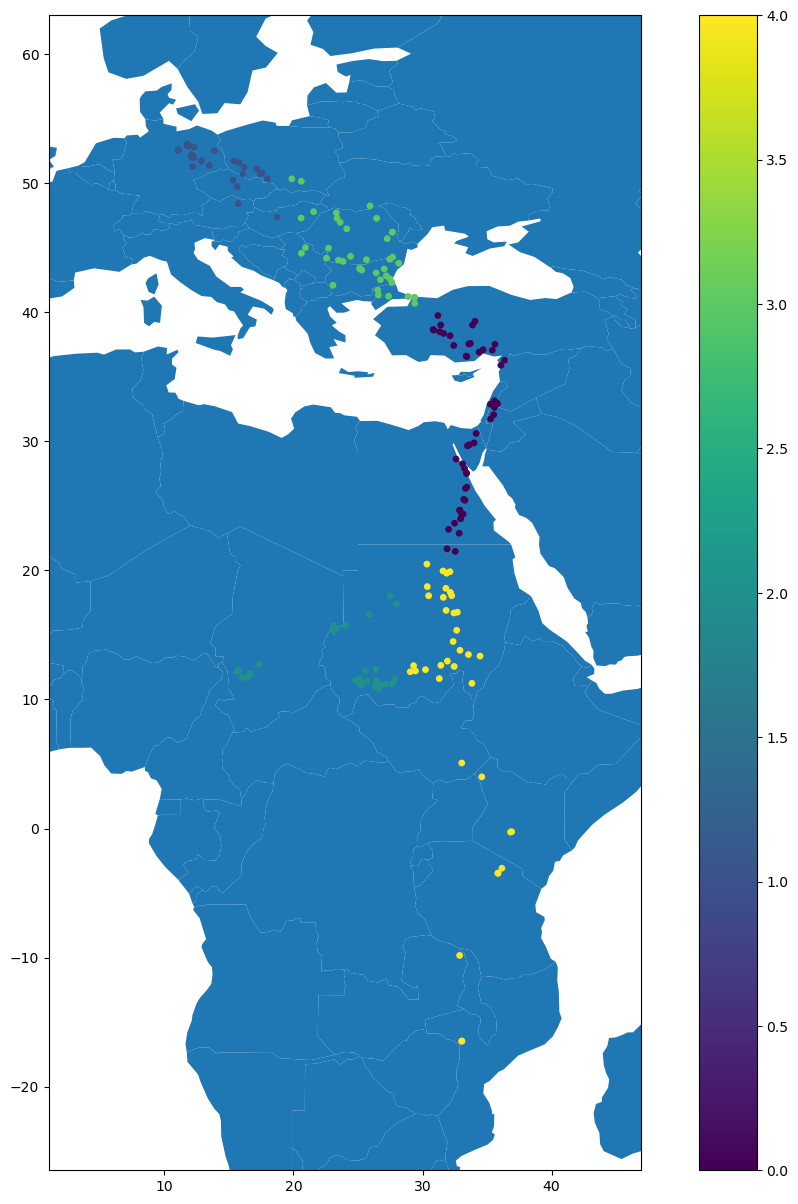

In [10]:
# Extract latitude and longitude columns
X = concatenated_df[['LastLatitude', 'LastLongitude']]

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply K-means clustering
kmeans = KMeans(n_clusters=5)  # You can change the number of clusters as needed
kmeans.fit(X_scaled)

# Assign cluster labels
concatenated_df['Region'] = kmeans.labels_

# Load world map data
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Convert latitude and longitude to Point objects
geometry = [Point(x,y) for x,y in zip(concatenated_df['LastLongitude'], concatenated_df['LastLatitude'])]

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(concatenated_df, geometry=geometry)


# Plot the world map
fig, ax = plt.subplots(figsize=(15, 15))
world.plot(ax=ax)

# Plot the clusters on the world map
gdf.plot(column='Region', cmap='viridis', legend=True, ax=plt.gca(),s=15)
plt.xlim(gdf['LastLongitude'].min() - 10, gdf['LastLongitude'].max() + 10)
plt.ylim(gdf['LastLatitude'].min() - 10, gdf['LastLatitude'].max() + 10)

plt.show()


In [11]:
concatenated_df = concatenated_df.drop(['LastLatitude','LastLongitude'],axis=1)
display(concatenated_df.head())

,Stork_id,Timestamp,NDVI,Temperature,RelativeHumidity,Rain,SurfacePressure,CloudCover,WindSpeed,Migrating,Region
0,2301,2014-04-07,1,2,1,0,1,1,0,0,1
1,2301,2014-04-14,1,2,1,0,1,0,0,0,1
2,2301,2015-01-26,1,0,0,0,0,0,0,1,2
3,2301,2015-02-02,1,0,0,0,0,0,0,0,2
4,2301,2015-02-09,1,1,0,0,0,0,0,0,2


### Transform for Dynamic Bayesian Network (DBN)

Insert type of format needed

In [157]:
for stork_id in concatenated_df['Stork_id'].unique().tolist():
    print(stork_id)
    subdata = concatenated_df[concatenated_df['Stork_id']==stork_id]
    subdata['Timestamp'] = pd.to_datetime(subdata['Timestamp'])

    # Create a new column 'order' containing the ordered indices
    subdata['Order'] = subdata['Timestamp'].rank(method='first').astype(int) - 1

    # Sort DataFrame by 'timestamp_column'
    subdata = subdata.sort_values(by='Timestamp')

    # Reset index to maintain consistency (optional)
    subdata = subdata.drop(['Timestamp','Stork_id'],axis=1)
    subdata = subdata.reset_index(drop=True)
    display(subdata.head())
    flattened_data = subdata.apply(lambda row: ','.join(map(str, row)), axis=1)
    print(flattened_data)

2301


,NDVI,Temperature,RelativeHumidity,Rain,SurfacePressure,CloudCover,WindSpeed,Migrating,Region,Order
0,0,0,1,0,1,0,1,0,0,0
1,0,1,0,1,0,0,1,1,0,1
2,0,1,0,1,0,0,1,0,1,2
3,0,2,0,0,0,0,0,0,1,3
4,1,2,0,0,0,0,1,0,1,4


0      0,0,1,0,1,0,1,0,0,0
1      0,1,0,1,0,0,1,1,0,1
2      0,1,0,1,0,0,1,0,1,2
3      0,2,0,0,0,0,0,0,1,3
4      1,2,0,0,0,0,1,0,1,4
5      1,2,1,1,1,1,0,0,1,5
6      1,2,1,0,1,0,0,0,1,6
7      0,1,0,0,0,0,0,1,0,7
8      0,0,0,0,0,0,0,0,0,8
9      0,1,0,0,0,0,1,0,0,9
10    0,0,1,1,1,1,1,1,0,10
11    0,0,1,1,1,1,0,1,0,11
12    0,0,1,1,0,1,0,1,0,12
13    0,1,0,1,0,0,1,1,1,13
14    0,1,0,0,0,0,0,0,1,14
15    1,2,1,0,1,1,0,0,1,15
16    1,2,1,0,1,0,0,0,1,16
17    1,0,0,0,0,0,0,1,0,17
18    1,0,0,0,0,0,0,0,0,18
19    1,1,0,0,0,0,0,0,0,19
20    1,0,0,1,0,1,0,0,0,20
21    1,0,1,1,1,1,1,0,0,21
22    0,0,1,1,1,1,1,1,0,22
23    0,1,1,0,1,1,0,1,0,23
24    0,0,0,1,0,0,1,0,0,24
25    0,1,0,0,0,0,1,1,1,25
26    0,2,0,0,0,0,0,1,1,26
27    1,2,1,0,1,0,0,0,1,27
28    1,2,1,0,1,0,0,0,1,28
29    1,0,0,0,0,0,0,1,0,29
30    1,0,0,0,0,0,0,0,0,30
31    1,0,0,0,0,1,0,0,0,31
32    1,1,0,0,1,0,1,0,0,32
33    1,1,1,0,1,1,1,0,0,33
34    1,0,1,0,1,1,0,1,0,34
35    0,0,1,1,0,1,1,1,0,35
36    0,1,0,1,0,1,0,0,0,36
3

,NDVI,Temperature,RelativeHumidity,Rain,SurfacePressure,CloudCover,WindSpeed,Migrating,Region,Order
0,0,2,0,0,0,0,0,0,0,0
1,0,2,0,0,0,0,0,0,0,1
2,0,1,0,0,1,0,1,1,0,2
3,0,1,1,1,1,1,1,0,0,3
4,1,1,0,0,0,0,0,1,0,4


0    0,2,0,0,0,0,0,0,0,0
1    0,2,0,0,0,0,0,0,0,1
2    0,1,0,0,1,0,1,1,0,2
3    0,1,1,1,1,1,1,0,0,3
4    1,1,0,0,0,0,0,1,0,4
5    1,1,0,1,0,0,1,1,1,5
6    1,2,0,1,0,0,0,1,1,6
7    1,2,1,1,1,0,0,0,1,7
8    1,2,1,0,1,0,0,0,1,8
dtype: object
2305


,NDVI,Temperature,RelativeHumidity,Rain,SurfacePressure,CloudCover,WindSpeed,Migrating,Region,Order
0,0,1,1,1,1,1,1,1,0,0
1,0,1,1,1,1,1,1,1,0,1
2,0,1,0,1,1,1,0,0,0,2
3,0,1,0,1,0,0,1,1,1,3
4,1,2,0,0,0,0,1,0,1,4


0      0,1,1,1,1,1,1,1,0,0
1      0,1,1,1,1,1,1,1,0,1
2      0,1,0,1,1,1,0,0,0,2
3      0,1,0,1,0,0,1,1,1,3
4      1,2,0,0,0,0,1,0,1,4
5      1,2,0,0,0,0,0,0,1,5
6      1,2,1,0,1,0,0,0,1,6
7      1,0,1,0,1,0,1,1,0,7
8      1,0,1,1,1,1,1,0,0,8
9      0,0,1,1,1,1,1,0,0,9
10    0,0,1,1,1,1,1,1,0,10
11    0,1,1,1,1,1,1,1,0,11
12    0,1,0,1,1,1,1,1,0,12
13    0,1,1,1,1,1,1,1,0,13
14    0,0,0,1,0,1,1,0,0,14
15    0,1,0,1,0,1,1,0,0,15
16    0,1,0,1,0,0,0,1,1,16
17    1,2,1,0,1,1,0,0,1,17
dtype: object
2306


,NDVI,Temperature,RelativeHumidity,Rain,SurfacePressure,CloudCover,WindSpeed,Migrating,Region,Order
0,0,0,1,1,0,1,1,1,0,0
1,0,0,1,1,1,1,1,1,0,1
2,0,1,1,1,1,1,1,1,0,2
3,0,1,0,0,0,0,1,0,0,3
4,1,1,0,0,0,0,1,0,1,4


0      0,0,1,1,0,1,1,1,0,0
1      0,0,1,1,1,1,1,1,0,1
2      0,1,1,1,1,1,1,1,0,2
3      0,1,0,0,0,0,1,0,0,3
4      1,1,0,0,0,0,1,0,1,4
5      1,2,0,0,0,0,0,1,1,5
6      1,2,1,0,1,0,1,0,1,6
7      0,1,0,0,0,0,0,1,0,7
8      0,0,0,0,0,0,0,0,0,8
9      0,1,0,0,0,0,1,0,0,9
10    0,0,0,1,0,1,1,1,0,10
11    0,0,1,1,1,1,0,1,0,11
12    0,0,1,1,1,1,1,1,0,12
13    0,1,0,1,0,0,1,1,1,13
14    0,2,1,0,1,1,0,0,1,14
15    1,2,1,0,1,1,1,0,1,15
16    1,0,0,0,0,0,1,1,0,16
17    1,0,0,0,0,0,0,0,0,17
18    1,0,1,1,0,1,0,0,0,18
19    1,0,1,1,1,1,1,1,0,19
20    0,0,1,1,1,1,1,1,0,20
21    0,0,1,0,1,1,1,1,0,21
22    0,1,0,1,0,1,0,0,0,22
23    0,1,1,1,0,1,1,0,1,23
24    0,2,0,0,0,0,0,1,1,24
25    1,2,1,0,0,0,0,0,1,25
26    1,2,1,0,1,0,0,0,1,26
27    1,0,1,1,1,1,1,1,0,27
28    1,0,1,1,1,1,1,0,0,28
29    1,0,1,1,1,1,0,1,0,29
30    1,1,1,0,1,1,1,1,0,30
31    0,0,1,0,1,0,1,1,0,31
32    0,1,0,1,0,1,1,1,0,32
33    0,2,0,0,0,1,0,0,1,33
34    0,2,0,1,0,0,1,1,1,34
35    0,2,1,1,1,1,0,0,1,35
36    1,2,1,0,1,1,1,0,1,36
d

,NDVI,Temperature,RelativeHumidity,Rain,SurfacePressure,CloudCover,WindSpeed,Migrating,Region,Order
0,0,1,1,0,1,1,1,0,0,0


0    0,1,1,0,1,1,1,0,0,0
dtype: object
1791


,NDVI,Temperature,RelativeHumidity,Rain,SurfacePressure,CloudCover,WindSpeed,Migrating,Region,Order
0,0,0,1,1,1,1,0,1,0,0
1,0,1,0,0,0,0,1,1,0,1
2,0,1,0,1,0,0,1,0,1,2
3,0,2,0,0,0,0,0,0,1,3
4,1,2,1,0,1,1,0,0,1,4


0      0,0,1,1,1,1,0,1,0,0
1      0,1,0,0,0,0,1,1,0,1
2      0,1,0,1,0,0,1,0,1,2
3      0,2,0,0,0,0,0,0,1,3
4      1,2,1,0,1,1,0,0,1,4
5      1,2,1,1,1,1,0,0,1,5
6      1,0,0,1,0,1,1,1,0,6
7      0,0,0,0,0,0,0,0,0,7
8      0,0,0,0,1,0,1,1,0,8
9      0,0,1,1,1,1,1,1,0,9
10    0,0,1,0,1,1,0,0,0,10
11    0,1,1,1,1,1,1,1,0,11
12    0,0,0,1,0,1,1,1,0,12
13    0,2,0,1,0,0,0,1,1,13
14    0,2,1,0,1,0,0,0,1,14
15    1,2,1,0,1,1,0,0,1,15
16    1,0,0,0,0,1,0,1,0,16
17    1,1,0,0,0,0,0,0,0,17
18    1,0,0,1,0,0,0,0,0,18
19    1,0,0,1,0,1,1,1,0,19
20    0,0,1,1,1,1,1,1,0,20
21    0,0,1,0,1,0,0,1,0,21
22    0,0,1,1,1,1,0,1,0,22
23    0,0,0,1,0,1,0,1,0,23
24    0,1,0,1,0,1,0,0,0,24
25    1,2,0,0,0,0,1,0,1,25
26    1,2,1,0,1,0,0,1,1,26
27    1,2,1,0,1,1,0,0,1,27
dtype: object
1793


,NDVI,Temperature,RelativeHumidity,Rain,SurfacePressure,CloudCover,WindSpeed,Migrating,Region,Order
0,0,1,1,0,1,0,1,1,0,0
1,0,0,1,1,1,1,1,1,0,1
2,0,0,1,1,1,1,1,0,0,2
3,0,1,1,1,1,1,1,0,0,3
4,1,1,0,0,0,0,1,0,0,4


0      0,1,1,0,1,0,1,1,0,0
1      0,0,1,1,1,1,1,1,0,1
2      0,0,1,1,1,1,1,0,0,2
3      0,1,1,1,1,1,1,0,0,3
4      1,1,0,0,0,0,1,0,0,4
5      1,2,0,0,0,0,1,1,1,5
6      1,2,1,1,1,0,1,0,1,6
7      1,2,1,1,1,0,0,0,1,7
8      0,0,1,1,1,1,1,1,0,8
9      0,1,1,0,1,1,1,0,0,9
10    0,0,1,1,1,1,0,1,0,10
11    0,0,1,1,0,1,0,1,0,11
12    0,1,1,0,1,0,0,1,0,12
13    0,1,1,0,1,0,1,1,0,13
14    1,1,1,1,1,1,0,0,0,14
15    1,1,0,1,0,1,0,1,0,15
16    1,2,0,1,0,0,0,1,1,16
17    1,2,0,0,1,1,0,1,1,17
18    1,2,1,0,1,0,0,0,1,18
19    1,0,0,0,0,1,0,1,0,19
20    1,0,1,1,1,1,1,0,0,20
21    0,0,1,1,1,1,1,0,0,21
22    0,0,1,1,1,1,0,1,0,22
23    0,0,1,1,1,1,0,1,0,23
24    0,1,0,1,0,1,0,1,1,24
25    0,2,0,1,0,0,0,1,1,25
26    1,2,0,0,0,0,0,0,1,26
27    1,2,1,0,1,0,0,0,1,27
dtype: object
1794


,NDVI,Temperature,RelativeHumidity,Rain,SurfacePressure,CloudCover,WindSpeed,Migrating,Region,Order
0,0,1,0,0,0,0,1,0,0,0
1,0,0,1,1,1,1,1,1,0,1
2,0,1,0,1,0,1,0,1,0,2
3,1,2,0,1,0,0,0,1,1,3
4,1,2,0,0,0,0,1,1,1,4


0      0,1,0,0,0,0,1,0,0,0
1      0,0,1,1,1,1,1,1,0,1
2      0,1,0,1,0,1,0,1,0,2
3      1,2,0,1,0,0,0,1,1,3
4      1,2,0,0,0,0,1,1,1,4
5      1,2,1,0,1,1,0,0,1,5
6      1,2,1,0,1,0,1,0,1,6
7      0,1,0,0,0,0,1,1,0,7
8      0,1,0,0,0,0,1,0,0,8
9      0,1,0,0,0,0,1,1,0,9
10    0,1,0,0,0,1,1,0,0,10
11    0,0,0,1,1,1,0,1,0,11
12    0,0,1,1,1,1,1,1,0,12
13    0,0,1,0,0,0,0,1,0,13
14    0,2,0,1,0,0,0,1,1,14
15    1,2,1,0,1,0,1,0,1,15
16    1,2,1,0,1,0,0,0,1,16
dtype: object
1796


,NDVI,Temperature,RelativeHumidity,Rain,SurfacePressure,CloudCover,WindSpeed,Migrating,Region,Order
0,0,1,1,1,1,1,1,1,0,0
1,0,1,0,1,0,1,1,1,0,1
2,0,1,0,1,0,1,0,0,0,2
3,0,2,0,1,0,0,0,0,0,3
4,1,2,0,1,0,0,1,0,0,4


0      0,1,1,1,1,1,1,1,0,0
1      0,1,0,1,0,1,1,1,0,1
2      0,1,0,1,0,1,0,0,0,2
3      0,2,0,1,0,0,0,0,0,3
4      1,2,0,1,0,0,1,0,0,4
5      1,2,0,0,0,0,0,1,1,5
6      1,2,1,1,1,0,0,0,1,6
7      1,2,1,1,1,0,1,0,1,7
8      1,0,0,1,0,1,1,1,0,8
9      0,1,0,0,0,0,0,0,0,9
10    0,0,0,0,0,0,0,0,0,10
11    0,1,1,1,1,1,1,1,0,11
12    0,0,1,1,1,1,0,0,0,12
13    0,1,0,1,0,1,1,1,0,13
14    0,1,0,1,0,0,1,1,1,14
15    0,2,0,0,0,0,0,1,1,15
16    0,2,1,0,1,1,1,0,1,16
17    1,2,1,0,1,1,0,0,1,17
dtype: object
1797


,NDVI,Temperature,RelativeHumidity,Rain,SurfacePressure,CloudCover,WindSpeed,Migrating,Region,Order
0,0,1,0,0,0,0,1,0,0,0
1,0,1,0,0,0,0,1,0,0,1
2,0,1,0,0,0,0,1,1,0,2
3,0,1,0,1,0,1,1,0,0,3
4,0,0,1,1,1,1,0,0,0,4


0      0,1,0,0,0,0,1,0,0,0
1      0,1,0,0,0,0,1,0,0,1
2      0,1,0,0,0,0,1,1,0,2
3      0,1,0,1,0,1,1,0,0,3
4      0,0,1,1,1,1,0,0,0,4
5      0,0,1,1,1,1,1,1,0,5
6      0,1,0,1,0,1,0,1,1,6
7      0,2,0,0,1,1,0,1,1,7
8      1,2,1,0,1,1,1,0,1,8
9      1,1,0,0,0,1,1,1,0,9
10    1,1,0,0,0,0,0,0,0,10
11    1,1,0,0,0,0,1,1,0,11
12    1,0,0,1,0,1,1,1,0,12
13    0,0,1,0,1,0,1,0,0,13
14    0,0,1,1,1,1,0,1,0,14
15    0,1,0,1,0,1,0,1,0,15
16    0,1,0,0,0,0,0,0,0,16
17    0,2,0,1,0,0,0,1,1,17
18    1,2,1,0,1,0,0,0,1,18
19    1,2,1,0,1,0,0,0,1,19
dtype: object
1787


,NDVI,Temperature,RelativeHumidity,Rain,SurfacePressure,CloudCover,WindSpeed,Migrating,Region,Order
0,0,1,1,1,1,1,1,1,0,0
1,0,0,1,1,1,1,1,1,0,1
2,0,0,1,1,1,1,1,1,0,2
3,0,2,0,1,0,0,0,1,1,3
4,1,2,0,0,0,0,1,1,1,4


0    0,1,1,1,1,1,1,1,0,0
1    0,0,1,1,1,1,1,1,0,1
2    0,0,1,1,1,1,1,1,0,2
3    0,2,0,1,0,0,0,1,1,3
4    1,2,0,0,0,0,1,1,1,4
5    1,2,1,1,1,0,0,0,1,5
6    1,2,1,1,1,0,0,0,1,6
dtype: object
